# LIB

In [ ]:
!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


# Downloading the dataset

In [ ]:
# Downloading the dataset and saving it automatically.

data_flag = 'dermamnist'

download = True # If it is set to false, then data won't be downloaded.

NUM_EPOCHS = 500
BATCH_SIZE = 128
lr = 0.05


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# dataloader

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 2005
    Root location: /roo

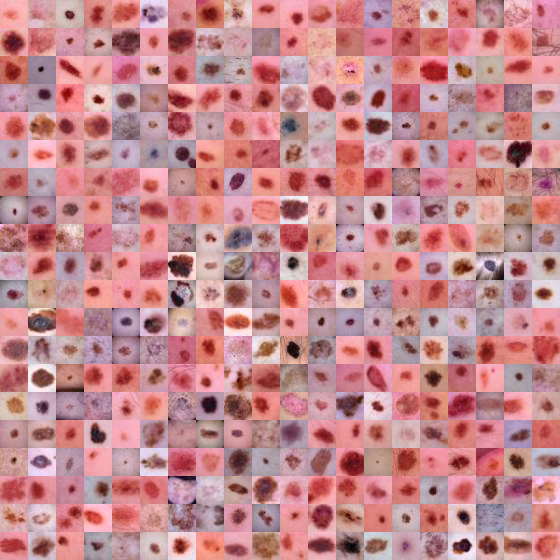

In [ ]:
test_dataset.montage(length=20)

# Visualising Data

In [ ]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2023-01-26 04:10:04--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  14.7MB/s    in 1.3s    

2023-01-26 04:10:08 (14.7 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [ ]:
data = np.load('Data.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [ ]:
print(f'Train Set:  X:%s Y:%s' %(data['train_images'].shape, data['train_labels'].shape))
print(f'Validation Set: X:%s Y:%s' %(data['val_images'].shape, data['val_labels'].shape))
print(f'Test Set :  X:%s Y:%s' %(data['test_images'].shape, data['test_labels'].shape))

Train Set:  X:(7007, 28, 28, 3) Y:(7007, 1)
Validation Set: X:(1003, 28, 28, 3) Y:(1003, 1)
Test Set :  X:(2005, 28, 28, 3) Y:(2005, 1)


In [ ]:
X_train = data['train_images']
X_val = data['val_images']
X_test = data['test_images']
X = np.concatenate((X_train, X_val, X_test), axis=0)

y_train = data['train_labels']
y_val = data['val_labels']
y_test = data['test_labels']
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [ ]:
labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma'
}

In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [ ]:
num_classes = []
for i in range(len(labels)):
  num_classes.append(len(np.where(y==i)[0]))

pd.DataFrame(num_classes,index=labels)

,0
akiec,327
bcc,514
bkl,1099
df,115
nv,1113
vasc,6705
mel,142


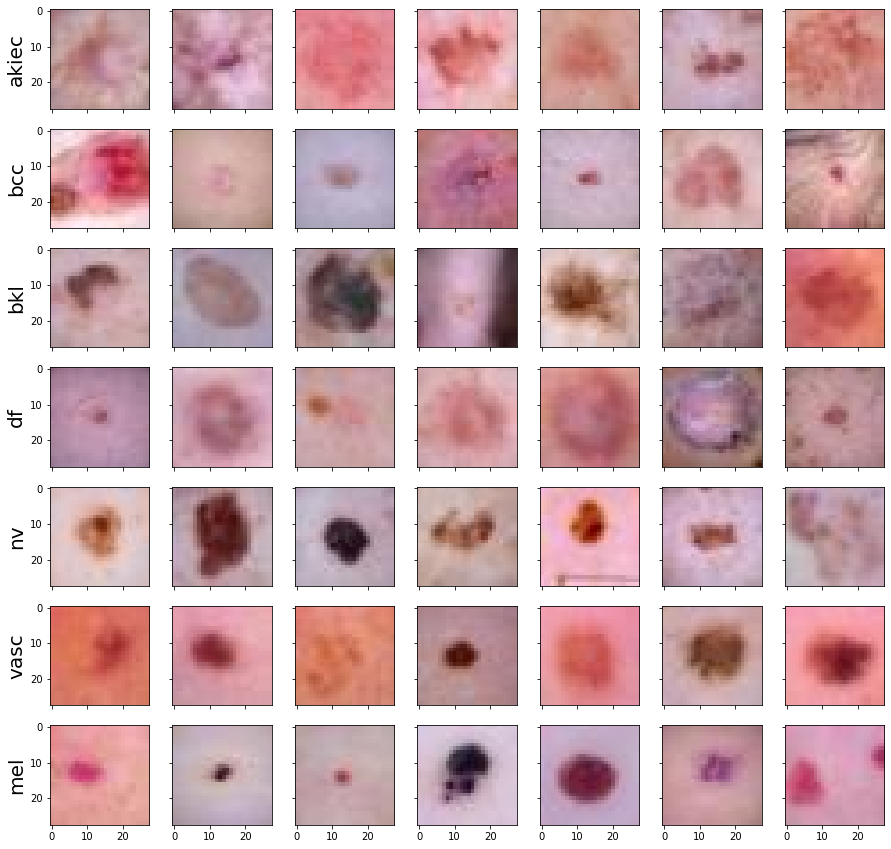

In [ ]:
fig, ax = plt.subplots(7,7)
fig.set_figheight(15)
fig.set_figwidth(15)
for classes in range (7):
  for i, inx in enumerate(np.where(y==classes)[0][:7]):
    ax[classes,i].imshow(X[inx])
    ax[classes,i].set_ylabel(labels[classes],fontsize = 20.0)
    ax[classes,i].label_outer()

# NETWORK -1

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 32
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-53-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
import torch
import torchvision

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

NameError: ignored

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
n_epochs=50
log_interval=10
learning_rate = 0.01
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-75-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.376558
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.299911
Train Epoch: 1 [2560/7007 (36%)]	Loss: 1.066159
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.083366
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.104810
Train Epoch: 1 [6400/7007 (91%)]	Loss: 0.880074

Test set: Avg. loss: 0.0004, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 0.866426
Train Epoch: 2 [1280/7007 (18%)]	Loss: 1.004662
Train Epoch: 2 [2560/7007 (36%)]	Loss: 0.984572
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.055753
Train Epoch: 2 [5120/7007 (73%)]	Loss: 0.915559
Train Epoch: 2 [6400/7007 (91%)]	Loss: 0.939199

Test set: Avg. loss: 0.0004, Accuracy: 1342/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 0.954024
Train Epoch: 3 [1280/7007 (18%)]	Loss: 1.118514
Train Epoch: 3 [2560/7007 (36%)]	Loss: 0.982170
Train Epoch: 3 [3840/7007 (55%)]	Loss: 0.878222
Train Epoch: 3 [5120/7007 (73%)]	Loss: 1.006634
Train Epoch: 3 [6400/7007 (91%)]	Loss: 1.142176

Test set: Avg. loss: 0.0004, Accu

In [ ]:
import matplotlib.pyplot as plt

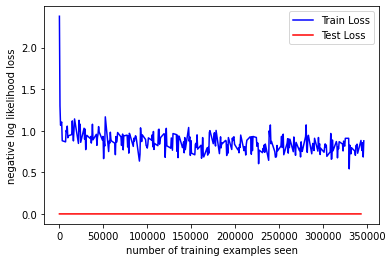

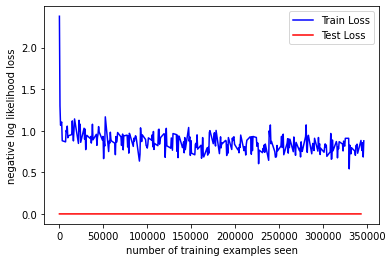

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

#  NETWORK - 2

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-86-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=25
log_interval=10
learning_rate = 0.05
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
n_epochs=25
log_interval=10
learning_rate = 0.05
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-86-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.267902
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.717507
Train Epoch: 1 [2560/7007 (36%)]	Loss: 1.305372
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.591622
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.013864
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.286776

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.041424
Train Epoch: 2 [1280/7007 (18%)]	Loss: 1.128999
Train Epoch: 2 [2560/7007 (36%)]	Loss: 1.290948
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.223857
Train Epoch: 2 [5120/7007 (73%)]	Loss: 1.165283
Train Epoch: 2 [6400/7007 (91%)]	Loss: 1.260914

Test set: Avg. loss: 0.0006, Accuracy: 1325/2005 (66%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.190137
Train Epoch: 3 [1280/7007 (18%)]	Loss: 1.123055
Train Epoch: 3 [2560/7007 (36%)]	Loss: 1.043297
Train Epoch: 3 [3840/7007 (55%)]	Loss: 0.946095
Train Epoch: 3 [5120/7007 (73%)]	Loss: 1.285909
Train Epoch: 3 [6400/7007 (91%)]	Loss: 1.228662

Test set: Avg. loss: 0.0006, Accu

# NETWORK - 3

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-95-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=80
log_interval=10
learning_rate = 0.7
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-95-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.298825
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.401491
Train Epoch: 1 [2560/7007 (36%)]	Loss: 1.205871
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.059883
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.348828
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.174590

Test set: Avg. loss: 0.0006, Accuracy: 1320/2005 (66%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.202646
Train Epoch: 2 [1280/7007 (18%)]	Loss: 0.965964
Train Epoch: 2 [2560/7007 (36%)]	Loss: 0.979693
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.696344
Train Epoch: 2 [5120/7007 (73%)]	Loss: 1.180753
Train Epoch: 2 [6400/7007 (91%)]	Loss: 1.138809

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.059720
Train Epoch: 3 [1280/7007 (18%)]	Loss: 0.890969
Train Epoch: 3 [2560/7007 (36%)]	Loss: 1.246713
Train Epoch: 3 [3840/7007 (55%)]	Loss: 1.007283
Train Epoch: 3 [5120/7007 (73%)]	Loss: 1.415886
Train Epoch: 3 [6400/7007 (91%)]	Loss: 1.101168

Test set: Avg. loss: 0.0005, Accu

# NETWORK - 4

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-113-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=110
log_interval=10
learning_rate = 0.9
momentum = 0.7
batch_size_train = 50
batch_size_test = 2500

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-113-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.268485
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.948565
Train Epoch: 1 [2560/7007 (36%)]	Loss: 0.969686
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.104344
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.155675
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.167476

Test set: Avg. loss: 0.0020, Accuracy: 1337/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.086879
Train Epoch: 2 [1280/7007 (18%)]	Loss: 1.097023
Train Epoch: 2 [2560/7007 (36%)]	Loss: 1.182854
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.232087
Train Epoch: 2 [5120/7007 (73%)]	Loss: 1.305887
Train Epoch: 2 [6400/7007 (91%)]	Loss: 1.199273

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.124139
Train Epoch: 3 [1280/7007 (18%)]	Loss: 1.151425
Train Epoch: 3 [2560/7007 (36%)]	Loss: 1.165960
Train Epoch: 3 [3840/7007 (55%)]	Loss: 1.293226
Train Epoch: 3 [5120/7007 (73%)]	Loss: 1.074151
Train Epoch: 3 [6400/7007 (91%)]	Loss: 0.993009

Test set: Avg. loss: 0.0006, Accu

KeyboardInterrupt: ignored

# network - 5

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-151-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=25
log_interval=10
learning_rate = 0.3
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-151-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.407247
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.027081
Train Epoch: 1 [2560/7007 (36%)]	Loss: 0.989252
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.136100
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.074433
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.159235

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 0.981277
Train Epoch: 2 [1280/7007 (18%)]	Loss: 0.941948
Train Epoch: 2 [2560/7007 (36%)]	Loss: 1.252765
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.236091
Train Epoch: 2 [5120/7007 (73%)]	Loss: 0.986056
Train Epoch: 2 [6400/7007 (91%)]	Loss: 0.971255

Test set: Avg. loss: 0.0005, Accuracy: 1342/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.004540
Train Epoch: 3 [1280/7007 (18%)]	Loss: 1.174511
Train Epoch: 3 [2560/7007 (36%)]	Loss: 0.832440
Train Epoch: 3 [3840/7007 (55%)]	Loss: 0.927329
Train Epoch: 3 [5120/7007 (73%)]	Loss: 0.960208
Train Epoch: 3 [6400/7007 (91%)]	Loss: 1.018119

Test set: Avg. loss: 0.0005, Accu

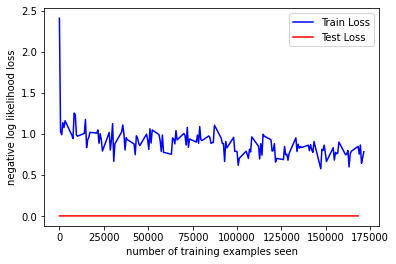

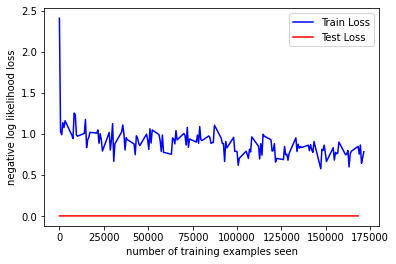

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# NETWORK - 6

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-166-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=350
log_interval=10
learning_rate = 0.5
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-166-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.318796
Train Epoch: 1 [1280/7007 (18%)]	Loss: 1.054159
Train Epoch: 1 [2560/7007 (36%)]	Loss: 1.114543
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.145867
Train Epoch: 1 [5120/7007 (73%)]	Loss: 1.226782
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.239339

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.174451
Train Epoch: 2 [1280/7007 (18%)]	Loss: 0.942362
Train Epoch: 2 [2560/7007 (36%)]	Loss: 1.157812
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.034000
Train Epoch: 2 [5120/7007 (73%)]	Loss: 0.907085
Train Epoch: 2 [6400/7007 (91%)]	Loss: 1.086908

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.026949
Train Epoch: 3 [1280/7007 (18%)]	Loss: 0.867418
Train Epoch: 3 [2560/7007 (36%)]	Loss: 1.014144
Train Epoch: 3 [3840/7007 (55%)]	Loss: 1.020917
Train Epoch: 3 [5120/7007 (73%)]	Loss: 0.957580
Train Epoch: 3 [6400/7007 (91%)]	Loss: 0.848359

Test set: Avg. loss: 0.0005, Accu

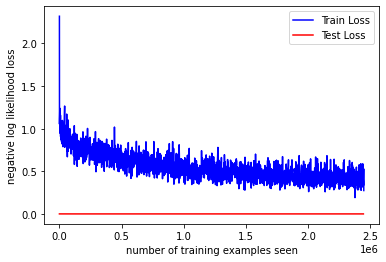

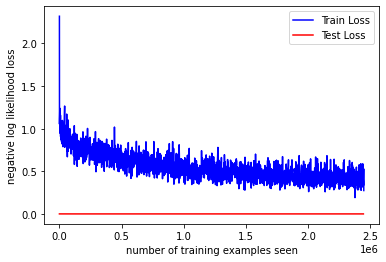

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# NETWORK - 7

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-180-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=175
log_interval=15
learning_rate = 0.8
momentum = 0.8
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-180-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.273394
Train Epoch: 1 [1920/7007 (27%)]	Loss: 1.278745
Train Epoch: 1 [3840/7007 (55%)]	Loss: 1.159310
Train Epoch: 1 [5760/7007 (82%)]	Loss: 1.203261

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.083064
Train Epoch: 2 [1920/7007 (27%)]	Loss: 1.123156
Train Epoch: 2 [3840/7007 (55%)]	Loss: 1.273429
Train Epoch: 2 [5760/7007 (82%)]	Loss: 1.085217

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.096542
Train Epoch: 3 [1920/7007 (27%)]	Loss: 1.198456
Train Epoch: 3 [3840/7007 (55%)]	Loss: 1.156119
Train Epoch: 3 [5760/7007 (82%)]	Loss: 1.227920

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 4 [0/7007 (0%)]	Loss: 0.957647
Train Epoch: 4 [1920/7007 (27%)]	Loss: 1.048571
Train Epoch: 4 [3840/7007 (55%)]	Loss: 1.038970
Train Epoch: 4 [5760/7007 (82%)]	Loss: 1.140217

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 5 [0/70

# NETWORK - 8

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-189-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=450
log_interval=25
learning_rate = 0.05
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-189-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/7007 (0%)]	Loss: 2.344666
Train Epoch: 1 [3200/7007 (45%)]	Loss: 1.039224
Train Epoch: 1 [6400/7007 (91%)]	Loss: 1.158276

Test set: Avg. loss: 0.0006, Accuracy: 1341/2005 (67%)

Train Epoch: 2 [0/7007 (0%)]	Loss: 1.042139
Train Epoch: 2 [3200/7007 (45%)]	Loss: 1.158201
Train Epoch: 2 [6400/7007 (91%)]	Loss: 1.093258

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 3 [0/7007 (0%)]	Loss: 1.086275
Train Epoch: 3 [3200/7007 (45%)]	Loss: 1.013294
Train Epoch: 3 [6400/7007 (91%)]	Loss: 0.952697

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 4 [0/7007 (0%)]	Loss: 0.902148
Train Epoch: 4 [3200/7007 (45%)]	Loss: 0.925074
Train Epoch: 4 [6400/7007 (91%)]	Loss: 0.993380

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 5 [0/7007 (0%)]	Loss: 1.034925
Train Epoch: 5 [3200/7007 (45%)]	Loss: 0.847562
Train Epoch: 5 [6400/7007 (91%)]	Loss: 1.015534

Test set: Avg. loss: 0.0005, Accuracy: 1341/2005 (67%)

Train Epoch: 6 

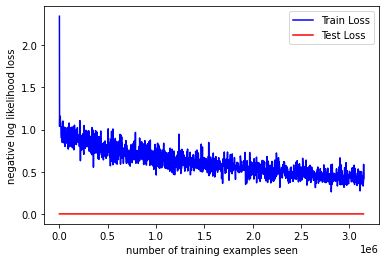

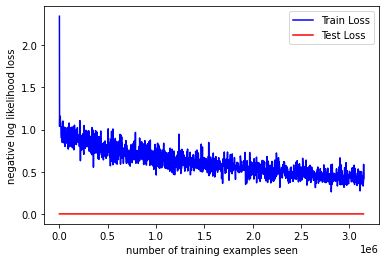

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# NETWORK - 9

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 1600)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        return F.log_softmax(x)

In [ ]:
x=torch.randn(256,3,28,28)
model=Net()
out=model(x)

<ipython-input-18-56adecd8ba5c>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
n_epochs=350
log_interval=9
learning_rate = 0.6
momentum = 0.5
batch_size_train = 64
batch_size_test = 1000

In [ ]:
network = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
import torch
import torchvision

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

NameError: ignored

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    target = target.squeeze().long()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      target = target.squeeze().long()
      test_loss = criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

NameError: ignored